## 0. All da Librariesss

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as ctx

In [3]:
df = pd.read_csv("Cyclist.csv") #Modified

## 1. Average Ride Duration by Member Type

*Goal* : Comparing how long casual vs members rides last on average.

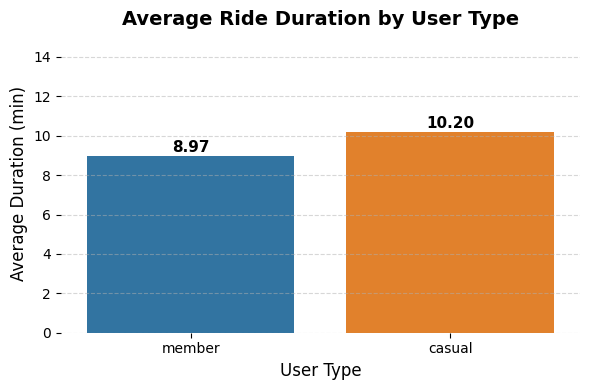

In [27]:
# Data
data = pd.DataFrame({
    'User Type': ['member', 'casual'],
    'Mean Duration (min)': [8.97, 10.20]
})

plt.figure(figsize=(6, 4))
sns.barplot(
    data=data,
    x='User Type',
    y='Mean Duration (min)',
    hue='User Type',
    palette=['#1f77b4', '#ff7f0e'],  # custom colors for clarity
    dodge=False
)

# Added value labels on top of bars
for index, row in data.iterrows():
    plt.text(index, row['Mean Duration (min)'] + 0.2, 
             f"{row['Mean Duration (min)']:.2f}", 
             ha='center', fontsize=11, weight='bold')

# Styling 👓
plt.title("Average Ride Duration by User Type", fontsize=14, weight='bold')
plt.xlabel("User Type", fontsize=12)
plt.ylabel("Average Duration (min)", fontsize=12)
plt.ylim(0, max(data['Mean Duration (min)']) + 5)
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine(left=True, bottom=True)  
plt.tight_layout()
plt.show()

## 2. Ride Popularity by Day of Week

*Goal:* Which days see the most rides?

/tmp/ipykernel_68673/2256327014.py:9: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




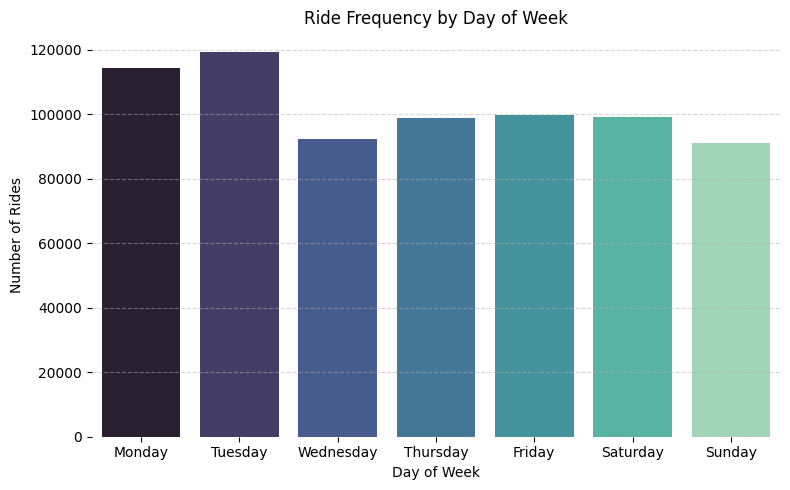

In [31]:
day_counts = df['started_day'].value_counts().reindex(
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
).reset_index()
day_counts.columns = ['started_day', 'count']

plt.figure(figsize=(8, 5))
sns.barplot(
    data=day_counts, 
    x='started_day', 
    y='count', 
    palette='mako',  # works now with data param
    dodge=False       # ensures bars are not split
)
plt.title("Ride Frequency by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Number of Rides")
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine(left=True, bottom=True)  
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## 3. Ride-Time Category Distribution

*Goal:* See how many rides fall into short, medium, or long durations.

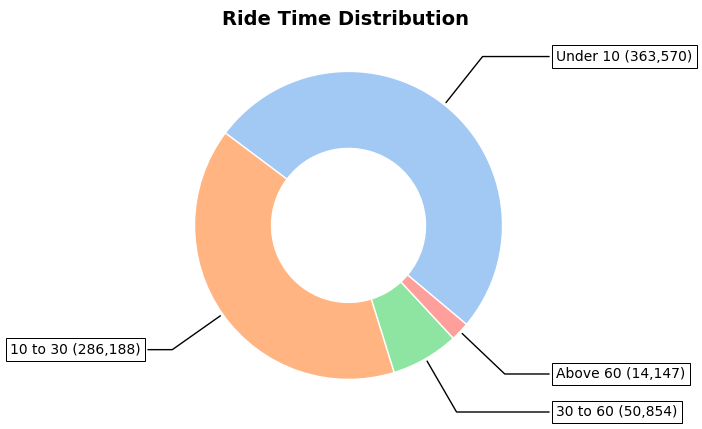

In [4]:
ride_time_counts = df['ride_time'].value_counts()
labels = ride_time_counts.index
data = ride_time_counts.values

fig, ax = plt.subplots(figsize=(8, 5), subplot_kw=dict(aspect="equal"))

wedges, texts = ax.pie(
    data,
    wedgeprops=dict(width=0.5, edgecolor='white'),
    startangle=-40,
    colors=sns.color_palette('pastel', len(data))
)


bbox_props = dict(boxstyle="square,pad=0.3", fc="white", ec="black", lw=0.72) # Annotation styles
kw = dict(
    arrowprops=dict(arrowstyle="-", lw=1.0),
    bbox=bbox_props, zorder=0, va="center"
)

for i, p in enumerate(wedges):  # Annotating each segment, ;-; its tough!!
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = f"angle,angleA=0,angleB={ang}"
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(
        f"{labels[i]} ({data[i]:,})",
        xy=(x, y),
        xytext=(1.35*np.sign(x), 1.4*y),
        horizontalalignment=horizontalalignment,
        fontsize=10,
        **kw
    )


ax.set_title("Ride Time Distribution ", fontsize=14, fontweight='bold')

plt.show()

## 4. Scatter Plot of Start Points

*Goal:* Visualize ride origins to see where users start most frequently.

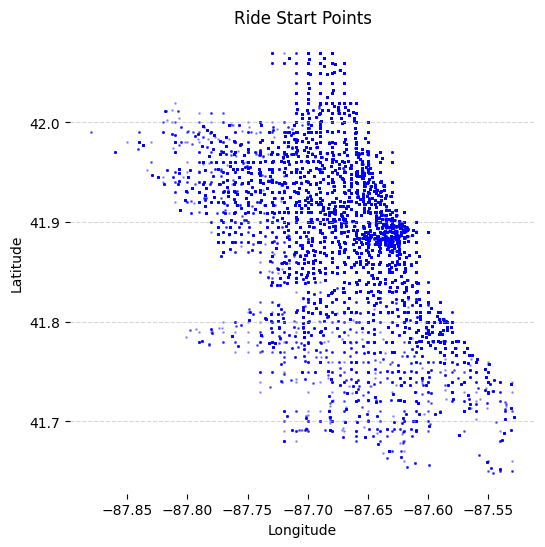

In [34]:
plt.figure(figsize=(6, 6))
plt.scatter(df['start_lng'], df['start_lat'], s=1, alpha=0.3, color='blue')
plt.title("Ride Start Points")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(axis='y', linestyle='--', alpha=0.5)
sns.despine(left=True, bottom=True)  
plt.show()


### 4.1 Member Vs Casual Comparison on map

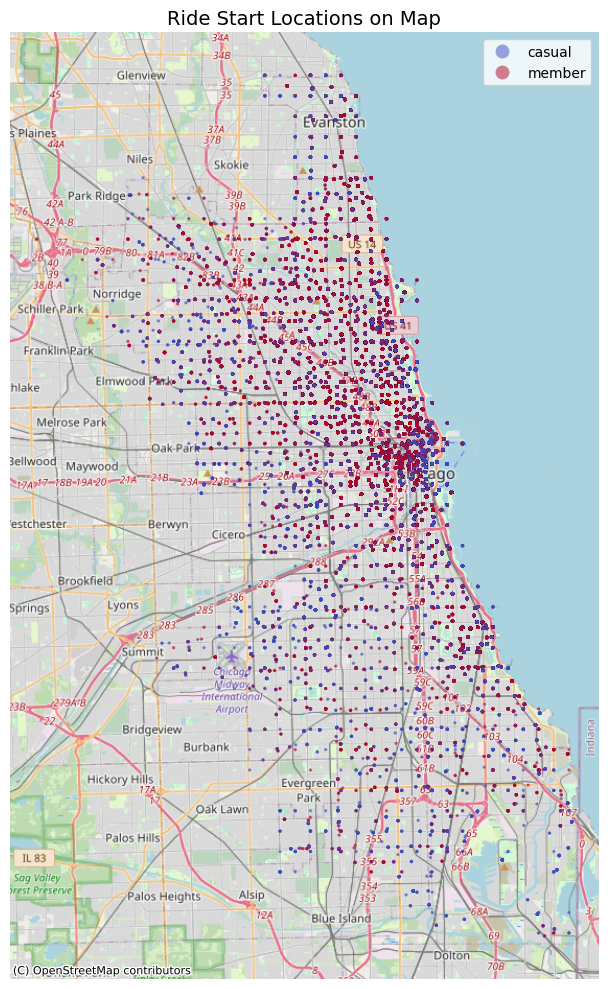

In [36]:
# GeoDataFrame
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df['start_lng'], df['start_lat']),
    crs="EPSG:4326"  # WGS84 (lat/lon)
)

gdf = gdf.to_crs(epsg=3857) # Converted to Web Mercator (needed for contextily)

fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax,
         markersize=2,
         alpha=0.5,
         column='member_casual',
         categorical=True,
         legend=True,
         cmap='coolwarm')

#Added basemap (OpenStreetMap)
ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)

plt.title("Ride Start Locations on Map", fontsize=14)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
ax.set_axis_off()
plt.tight_layout()
plt.show()



## 5. Ride-Time Category vs User Type

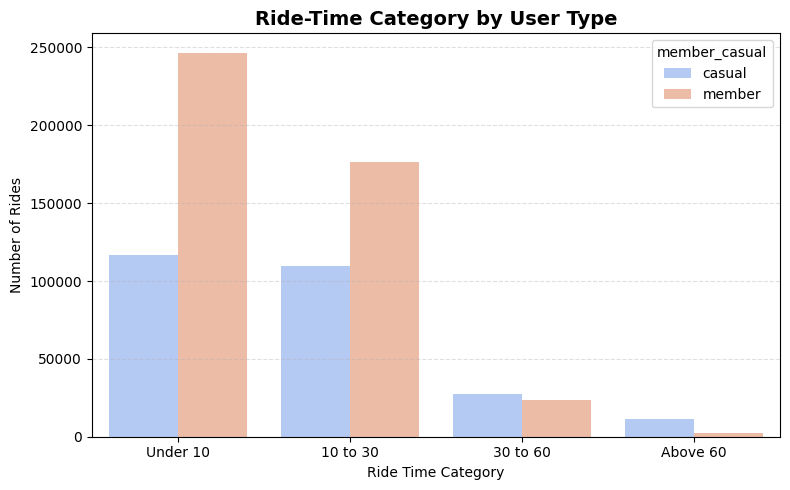

In [33]:
ride_time_counts = df.groupby(['ride_time', 'member_casual']).size().reset_index(name='count')

ride_order = ['Under 10', '10 to 30', '30 to 60', 'Above 60']

plt.figure(figsize=(8, 5))
sns.barplot(data=ride_time_counts,
            x='ride_time',
            y='count',
            hue='member_casual',
            order=ride_order,
            palette='coolwarm')

plt.title("Ride-Time Category by User Type", fontsize=14, weight='bold')
plt.xlabel("Ride Time Category")
plt.ylabel("Number of Rides")
plt.grid(axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## 6. Summary Table

In [28]:
summary_table = df.groupby('member_casual').agg(
    Total_Rides=('total_time_min', 'count'),
    Mean_Duration=('total_time_min', 'mean'),
    Median_Duration=('total_time_min', 'median'),
    Min_Duration=('total_time_min', 'min'),
    Max_Duration=('total_time_min', 'max')
).reset_index()

summary_table

,member_casual,Total_Rides,Mean_Duration,Median_Duration,Min_Duration,Max_Duration
0,casual,265461,10.204019,11.39,-1439.51,1210.41
1,member,449298,8.965965,9.09,-1438.83,1065.83


## 7. Orignal data summary

In [38]:
df_org = pd.read_csv("202509-divvy-tripdata.csv")

In [43]:
df_org.columns

Index(['ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual'],
      dtype='object')

In [47]:
df_org.isnull().sum()

ride_id                    0
rideable_type              0
started_at                 0
ended_at                   0
start_station_name    156261
start_station_id      156261
end_station_name      164483
end_station_id        164483
start_lat                  0
start_lng                  0
end_lat                  619
end_lng                  619
member_casual              0
dtype: int64

### 1. Rideable type counts by user type:

In [48]:
df_org.groupby(['member_casual','rideable_type']).size()


member_casual  rideable_type
casual         classic_bike      81295
               electric_bike    184166
member         classic_bike     158034
               electric_bike    291264
dtype: int64

### Rides per hour of day (extract hour from started_at):

In [49]:
df_org['started_hour'] = pd.to_datetime(df_org['started_at']).dt.hour
df_org.groupby('started_hour').size()

started_hour
0      9480
1      5772
2      3699
3      2196
4      2005
5      5308
6     16272
7     32710
8     42056
9     29399
10    28557
11    35354
12    41474
13    40119
14    41244
15    48708
16    65567
17    75268
18    63080
19    42461
20    27659
21    24144
22    19546
23    12681
dtype: int64

In [51]:
(df['total_time_min'] < 0).sum()


np.int64(2673)